# Nachstellung der Berechungen für Masterarbeit in Python

## Universelle Werte und Religion: Eine Sekundärdatenanalyse zum Zusammenhang von Wertorientierungen und Religiosität in Deutschland

Datengrundlage: European Social Survey (Round 6): https://www.europeansocialsurvey.org/

Basierend auf Theorie universeller menschlicher Werte von S. Schwartz: https://en.wikipedia.org/wiki/Theory_of_Basic_Human_Values

Nachgerechnet wird Teil II: Werte und Religiosität

Die Theorie prognostiziert, dass sich die Korrelationen der Schwartz-Werte mit Religiosität als Sinusförmige Kurve darstellen lassen. Stärkste negative Korrelation (-> Zustimmung) bei Tradition, stärkste positive Korrelation (-> Ablehnung) bei Hedonism.


Quelle: Schwartz, Shalom H. / Huismans, Sipke (1995): Value Priorities and Religiosity in Four Western Religions. In:  Social Psychology Quarterly, Vol. 58, No. 2 (Jun., 1995), pp. 88-107 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True) 

 
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import pingouin as pg

In [2]:
ess = pd.read_csv('daten/ess6de.csv',sep=';',low_memory=False,keep_default_na=True,na_values=['',' '])

/home/alex/miniconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning:

The package pingouin is out of date. Your version is 0.3.8, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.

/home/alex/miniconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning:

The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.



In [3]:
ess.head()

,name,essround,edition,proddate,idno,cntry,tvtot,tvpol,ppltrst,pplfair,...,inwemm,inwtm,spltadme,supqad1,supqad2,supqdd,supqmm,supqyr,dweight,pweight
0,ESS6e01_2,6,1.2,13.01.2014,11000031,DE,2.0,1.0,3.0,8.0,...,37,47.0,1,NaN,1,13,9,2012,"1,23695315465278","2,400664469"
1,ESS6e01_2,6,1.2,13.01.2014,11000041,DE,7.0,5.0,7.0,7.0,...,23,82.0,1,NaN,1,20,9,2012,"1,23695315465278","2,400664469"
2,ESS6e01_2,6,1.2,13.01.2014,11000051,DE,3.0,1.0,3.0,5.0,...,41,63.0,1,NaN,1,20,9,2012,"0,540573923441953","2,400664469"
3,ESS6e01_2,6,1.2,13.01.2014,11000061,DE,7.0,1.0,6.0,5.0,...,7,53.0,1,NaN,1,30,11,2012,"1,23695315465278","2,400664469"
4,ESS6e01_2,6,1.2,13.01.2014,11000071,DE,4.0,1.0,5.0,6.0,...,58,57.0,1,NaN,1,21,9,2012,"1,23695315465278","2,400664469"


## Filter

Filtereinstellungen

In [4]:
filter_vars = {
    'name' : {
      'ESS6e01_2':'Insgesamt'  
    },
    'rlgdnm': {
        1 : 'Katholiken',
        2 : 'Protestanten',
    },
    'rlgblg' : {
        2 : 'konfessionslos',
    },
    'intewde' : {
        1 : 'Ostdeutschland',
        2 : 'Westdeutschland'
    }
}

## Schwarz Werte

In [5]:
schwarz_items = {
    'selfdirection' : ['ipcrtiv','impfree'],
    'stimulation' : ['impdiff', 'ipadvnt'],
    'hedonism' : ['ipgdtim', 'impfun'],
    'achievement' : ['ipshabt', 'ipsuces'],
    'power' : ['imprich', 'iprspot'],
    'security' :['impsafe', 'ipstrgv'],
    'conformity' : ['ipfrule', 'ipbhprp'],
    'tradition' : ['ipmodst', 'imptrad'],
    'benevolence' : ['iphlppl', 'iplylfr'],
    'universalism' : ['ipeqopt', 'ipudrst', 'impenv'],    
}

In [6]:
def compute_schwarz_values(df,schwarz_items):
    '''
    Computes Schwarz values as mean of questionaire items.
    '''
    for value in schwarz_items:
        items = schwarz_items[value]
        df[value] = df[items].mean(axis=1)
    return df

def CronbachAlpha(itemscores):
    '''
    See: 
    https://mathtuition88.com/2019/09/13/calculate-cronbach-alpha-using-python/
    '''
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]

    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

In [7]:
ess = compute_schwarz_values(ess,schwarz_items)

In [8]:
print('Cronbachs Alpha')
for value in schwarz_items:
    items = schwarz_items[value]
    alpha = CronbachAlpha(ess[items].dropna())
    print(value, ':\t',alpha)

Cronbachs Alpha
selfdirection :	 0.416698211306177
stimulation :	 0.5847756245253464
hedonism :	 0.7008337908072337
achievement :	 0.6445502207667455
power :	 0.37837202427731187
security :	 0.5632188858884548
conformity :	 0.540205009242539
tradition :	 0.32663078389763633
benevolence :	 0.5284161639842846
universalism :	 0.4548159927725508


Mittelwert über alle Werte je Person zur Kontrolle von Skalennutzungseffekten:

In [9]:
ess['mittelwschwartz'] = ess[schwarz_items.keys()].mean(axis=1)

## Index Religiosität

"How religious are you?"
0 = not at all
1 = very

In [10]:
ess['rlgdgr_neu'] = ess['rlgdgr']*0.1
#ess[['rlgdgr','rlgdgr_neu']]

Umkodieren Attend religous services.
1 'Every Day' 0.274 'More than once a day' 0.142 'Once a week' 0.033 'At least once a month' 0.008 'Only on special holy days' 0.002 'Less often' 0 'Never'.

In [11]:
recode_dict = {
    1:1,
    2:0.274,
    3:0.142,
    4:0.033,
    5:0.008,
    6:0.002,
    7:0,
}
recode_dict

{1: 1, 2: 0.274, 3: 0.142, 4: 0.033, 5: 0.008, 6: 0.002, 7: 0}

In [12]:
ess['rlgatnd_neu'] = ess['rlgatnd'].replace(recode_dict)

Umkodieren Gebetshäufigkeit (gleiche Ausprägungen)

In [13]:
ess['pray_neu'] = ess['pray'].replace(recode_dict)

Reabilität Neue SKala (Cronbach)

In [14]:
CronbachAlpha(ess[['rlgdgr_neu', 'rlgatnd_neu', 'pray_neu']].dropna())

0.6005552972413457

### Faktorenanalyse

In [15]:
df = ess[['rlgdgr_neu', 'rlgatnd_neu', 'pray_neu']]

In [16]:
fa = FactorAnalyzer(rotation=None)

In [17]:
fa.fit(df)

FactorAnalyzer(rotation=None, rotation_kwargs={})

In [18]:
fa.loadings_

array([[ 0.70808694, -0.14297856,  0.07222166],
       [ 0.50612015,  0.24021599,  0.03294684],
       [ 0.7561938 , -0.02689377, -0.08967843]])

Text(0, 0.5, 'Eigenvalue')

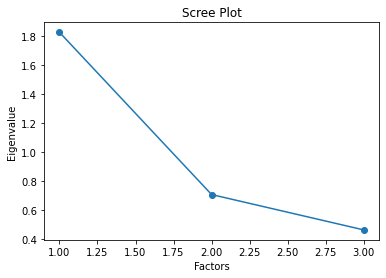

In [19]:
ev, v = fa.get_eigenvalues()
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')

Berechne Index

In [20]:
ess['relig_index'] = ess['rlgdgr_neu'] + ess['rlgatnd_neu'] + ess['pray_neu']

In [21]:
ess[['rlgdgr_neu','rlgatnd_neu','pray_neu','relig_index']]

,rlgdgr_neu,rlgatnd_neu,pray_neu,relig_index
0,0.9,0.008,0.033,0.941
1,0.6,0.000,1.000,1.600
2,0.0,0.000,0.000,0.000
3,0.5,0.008,0.002,0.510
4,0.0,0.000,0.000,0.000
...,...,...,...,...
2953,0.3,0.000,0.000,0.300
2954,0.8,0.000,0.000,0.800
2955,0.7,0.008,0.002,0.710
2956,0.5,0.002,1.000,1.502


### Lage und Streuungsmaße

In [22]:
ess['relig_index'].describe()

count    2922.000000
mean        0.619773
std         0.617708
min         0.000000
25%         0.100000
50%         0.502000
75%         0.850000
max         3.000000
Name: relig_index, dtype: float64

Nach Konfession (1= kath; 2 = Prot)

In [23]:
df_list = []
for var in filter_vars:
    filters = filter_vars[var].keys()
    descriptives = ess.groupby(var)['relig_index'].describe()
    relevant_groups = descriptives.loc[filters,:]
    rename = relevant_groups.rename(index=filter_vars[var])
    df_list.append(rename)
df_relig_index = pd.concat(df_list, axis=0).T
df_relig_index

,Insgesamt,Katholiken,Protestanten,konfessionslos,Ostdeutschland,Westdeutschland
count,2922.000000,663.000000,794.000000,1282.000000,1007.000000,1915.000000
mean,0.619773,0.986014,0.832034,0.235396,0.359504,0.756636
std,0.617708,0.611624,0.563115,0.374045,0.512779,0.624283
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.100000,0.510000,0.500000,0.000000,0.000000,0.302000
50%,0.502000,0.776000,0.635000,0.100000,0.200000,0.604000
75%,0.850000,1.508000,1.007000,0.308000,0.508000,1.007000
max,3.000000,3.000000,2.274000,2.142000,3.000000,3.000000


Mittelwerte Schwarz Values

In [24]:
df_list = []
for var in filter_vars:
    filters = filter_vars[var].keys()
    descriptives = ess.groupby(var)[list(schwarz_items.keys())].mean()
    relevant_groups = descriptives.loc[filters,:]
    rename = relevant_groups.rename(index=filter_vars[var])
    df_list.append(rename)
df_schwarz = pd.concat(df_list, axis=0).T
df_schwarz

,Insgesamt,Katholiken,Protestanten,konfessionslos,Ostdeutschland,Westdeutschland
selfdirection,2.152905,2.240573,2.164392,2.104425,2.196322,2.130356
stimulation,3.529552,3.571644,3.719331,3.423913,3.631213,3.476780
hedonism,2.727427,2.745865,2.859356,2.630823,2.705765,2.738660
achievement,3.064029,3.056561,3.206320,3.006599,3.080020,3.055728
power,3.827334,3.780120,3.910161,3.811335,3.853380,3.813822
security,2.300781,2.267669,2.301489,2.321817,2.131710,2.388545
conformity,3.164118,3.105422,3.108561,3.258540,3.000994,3.248838
tradition,2.687882,2.505263,2.475217,2.935559,2.552187,2.758247
benevolence,1.800442,1.785068,1.793680,1.824146,1.803678,1.798762
universalism,2.030493,2.036341,2.001859,2.067029,2.049370,2.020704


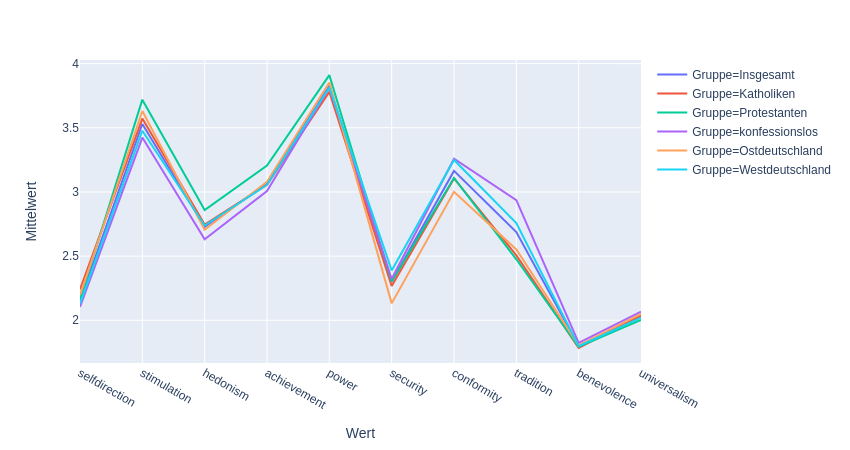

In [25]:
df = df_schwarz.stack().reset_index().rename(columns={'level_0':'Wert','level_1':'Gruppe',0:'Mittelwert'})
px.line(df,x='Wert',y='Mittelwert',line_group='Gruppe',color='Gruppe')

## Korrelationen

In [26]:
pg.partial_corr(data=ess, x='selfdirection', y='relig_index').round(3)

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,2909,0.009,"[-0.03, 0.05]",0.0,-0.001,0.611,0.026,0.08


In [27]:
def part_corr_value(ess,schwarz_items):
    df = pd.DataFrame()
    for value in schwarz_items:
        corr = pg.partial_corr(data=ess, 
                               x=value, 
                               y='relig_index',
                               covar=['mittelwschwartz','agea','eisced','hinctnta','gndr','domicil'])
        corr = corr.round(3).rename(index={'pearson':value})
        df = df.append(corr)
    return df

In [28]:
df = part_corr_value(ess,schwarz_items)

In [29]:
df

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
selfdirection,2512,0.031,"[-0.01, 0.07]",0.001,0.000,0.121,0.083,0.341
stimulation,2514,0.047,"[0.01, 0.09]",0.002,0.001,0.018,0.405,0.656
hedonism,2514,0.140,"[0.1, 0.18]",0.020,0.019,0.000,1.549e+09,1.000
achievement,2514,0.099,"[0.06, 0.14]",0.010,0.009,0.000,5433.914,0.999
power,2513,0.052,"[0.01, 0.09]",0.003,0.002,0.009,0.726,0.738
security,2514,0.034,"[-0.01, 0.07]",0.001,0.000,0.089,0.106,0.399
conformity,2513,-0.062,"[-0.1, -0.02]",0.004,0.003,0.002,2.957,0.871
tradition,2514,-0.213,"[-0.25, -0.18]",0.046,0.045,0.000,6.25e+23,1.000
benevolence,2513,-0.058,"[-0.1, -0.02]",0.003,0.003,0.003,1.813,0.834
universalism,2514,-0.101,"[-0.14, -0.06]",0.010,0.009,0.000,9851.194,0.999


In [30]:
def confidence_intervalls(df):
    df[['error_y_minus','error_y']] = pd.DataFrame(df['CI95%'].tolist(),index=df.index)
    #df['error_y_minus'] = df['r']+df['error_y_minus']
    #df['error_y'] = df['r']+df['error_y']
    # für Fehlerbalken. Plotly will Abweichung hier sind aber absolute Werte
    df['error_y_minus'] = df['r']-df['error_y_minus']
    df['error_y'] = df['error_y']-df['r']
    return df

In [31]:
df = confidence_intervalls(df)

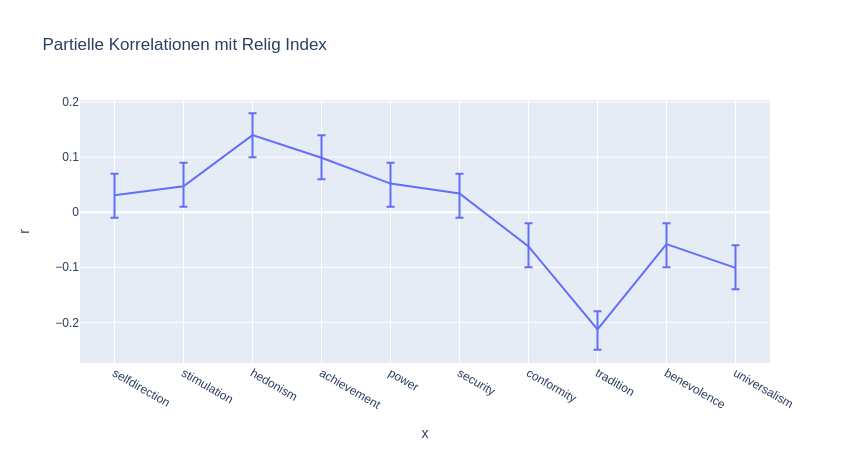

In [32]:
px.line(df,x=df.index,y='r',
        title='Partielle Korrelationen mit Relig Index',
        error_y='error_y',error_y_minus='error_y_minus')

In [33]:
df_list = pd.DataFrame()
for var in filter_vars:
    filters = filter_vars[var].keys()
    #print(filters)
    for group_nr in filters:
        group_name = filter_vars[var][group_nr]
        #print(group_name)
        relevant_groups = ess.loc[ess[var]==group_nr,:]
        #print(relevant_groups)
        corrs = part_corr_value(relevant_groups,schwarz_items)#.reset_index()
        corrs['Gruppe'] = group_name
        #print(corrs)
        corrs = confidence_intervalls(corrs)
        df_list = df_list.append(corrs,)#ignore_index=True)
df_list.head()

,n,r,CI95%,r2,adj_r2,p-val,BF10,power,Gruppe,error_y_minus,error_y
selfdirection,2512,0.031,"[-0.01, 0.07]",0.001,0.000,0.121,0.083,0.341,Insgesamt,0.041,0.039
stimulation,2514,0.047,"[0.01, 0.09]",0.002,0.001,0.018,0.405,0.656,Insgesamt,0.037,0.043
hedonism,2514,0.140,"[0.1, 0.18]",0.020,0.019,0.000,1.549e+09,1.000,Insgesamt,0.040,0.040
achievement,2514,0.099,"[0.06, 0.14]",0.010,0.009,0.000,5433.914,0.999,Insgesamt,0.039,0.041
power,2513,0.052,"[0.01, 0.09]",0.003,0.002,0.009,0.726,0.738,Insgesamt,0.042,0.038


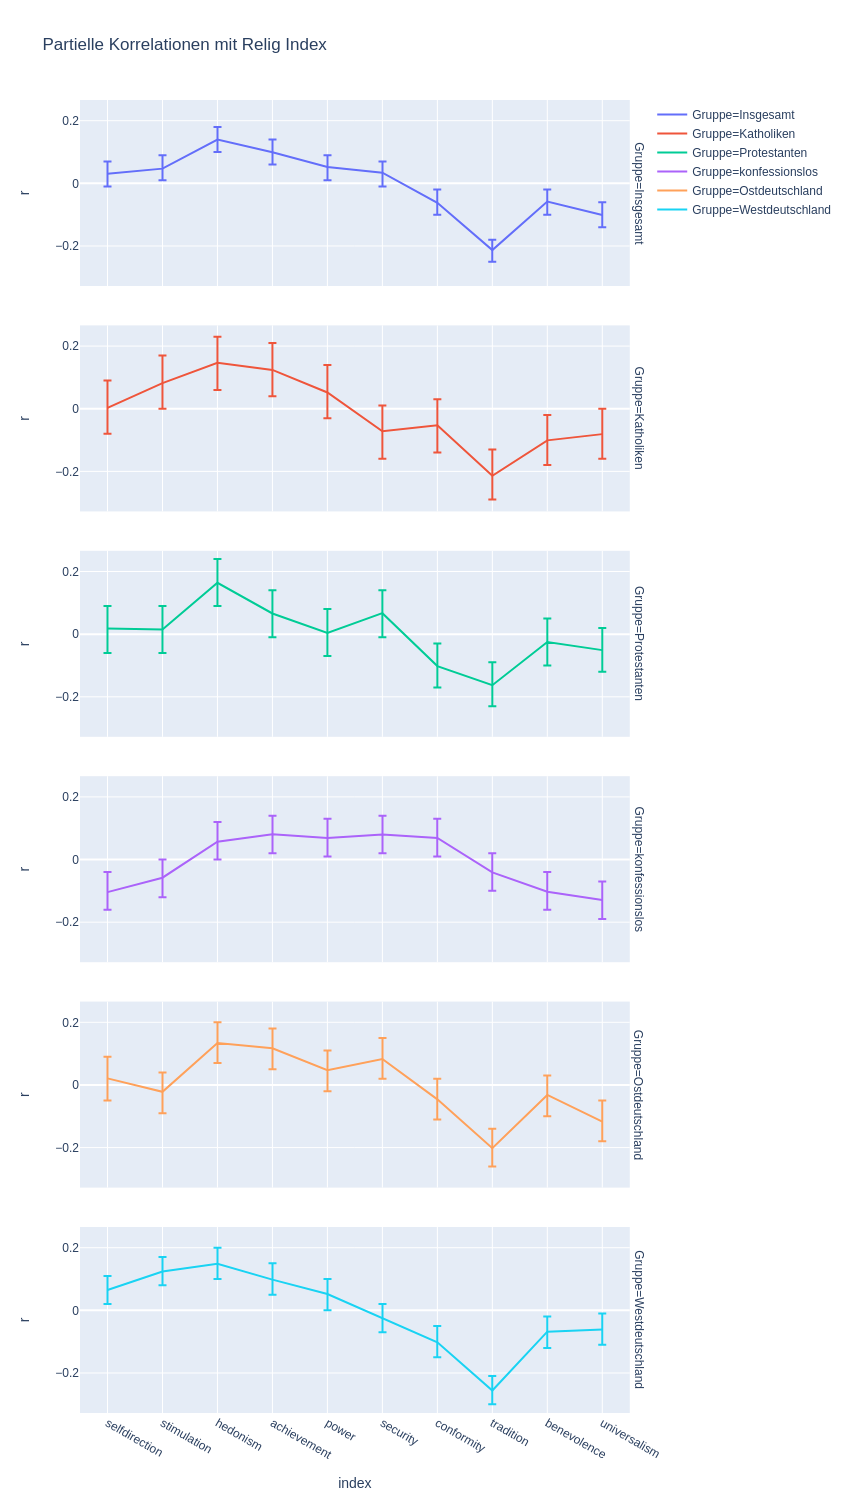

In [34]:
px.line(df_list.reset_index(),x='index',y='r',
        title='Partielle Korrelationen mit Relig Index',
        error_y='error_y',error_y_minus='error_y_minus',
       #line_group='Gruppe',
        color='Gruppe',facet_row='Gruppe',
       height=1500)

In [35]:
#df_list[['r','Gruppe']].reset_index().set_index(['index','Gruppe']).unstack(level=1)
df_list[['r','Gruppe']].set_index([df_list.index,'Gruppe']).unstack(level=1)

r                                         \
Gruppe        Insgesamt Katholiken Ostdeutschland Protestanten   
achievement       0.099      0.124          0.117        0.066   
benevolence      -0.058     -0.101         -0.032       -0.025   
conformity       -0.062     -0.053         -0.046       -0.102   
hedonism          0.140      0.147          0.134        0.164   
power             0.052      0.052          0.047        0.004   
security          0.034     -0.072          0.083        0.067   
selfdirection     0.031      0.003          0.021        0.018   
stimulation       0.047      0.082         -0.022        0.015   
tradition        -0.213     -0.214         -0.202       -0.163   
universalism     -0.101     -0.081         -0.117       -0.051   

                                              
Gruppe        Westdeutschland konfessionslos  
achievement             0.098          0.081  
benevolence            -0.068         -0.103  
conformity             -0.102          0.069  
hedonism                0.149          0.057  
power                   0.052          0.069  
security               -0.024          0.080  
selfdirection           0.065         -0.104  
stimulation             0.124         -0.058  
tradition              -0.256         -0.041  
universalism           -0.061         -0.129